### demonstrating camera calibration  20221223 CJH
* making the entire list of activities from the opencv docs on camera calibration
* https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html


#### import the necessary libraries

In [1]:
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import pandas as pd
import pickle

In [2]:
def predict_intrinsics(w, h, fov_x, fov_y, fov_diag=None):
    # ToDo - make a fov x,y guess if fed a diagonal fov
    fx_predicted =  0.5 * w / np.tan(0.5 * np.deg2rad(fov_x)) 
    fy_predicted =  0.5 * h / np.tan(0.5 * np.deg2rad(fov_y)) 
    cx = w//2
    cy = h//2
    apriltag_intrinsics = [round(fx_predicted,1), round(fy_predicted,1), cx, cy]
    cv_array = np.array([[fx_predicted,0,cx],[0,fy_predicted,cy],[0,0,1]])
    print(f'({w}x{h}) with x_fov {fov_x}° and y_fov {fov_y}° predicts nominal values of:')
    print(f'fx:{fx_predicted:4.1f}  fy:{fy_predicted:4.1f}  cx:{cx:3d}  cy:{cy:3d}')
    print(f'use the following with apriltag detector: {apriltag_intrinsics}')
    return apriltag_intrinsics, cv_array

In [3]:
predict_intrinsics(1280, 720, 60.2, 36.1)

(1280x720) with x_fov 60.2° and y_fov 36.1° predicts nominal values of:
fx:1104.1  fy:1104.7  cx:640  cy:360
use the following with apriltag detector: [np.float64(1104.1), np.float64(1104.7), 640, 360]


([np.float64(1104.1), np.float64(1104.7), 640, 360],
 array([[1.10405794e+03, 0.00000000e+00, 6.40000000e+02],
        [0.00000000e+00, 1.10468497e+03, 3.60000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

#### get images from camera  - can be webcam or external USB
* change the usb_index from 0 to something else if you have more than one camera
* loop through images - try to get a dozen before you quit, kicks you out at 16
  * press a for next / delete (don't save)
  * s for save the current image
  * q for quit


#### you need to keep the image at roughly the **same distance** for a good cal
* use the WIDTH guide you to keep same width (except when rotating - rely on h)
* use the HEIGHT to guide you to keep the same height (except when tilting - rely on w)
* **you need to tilt up/down AND left/right**

In [4]:
resolution = (1280, 720)  # try to capture images at this resolution, but cams don't always listen
usb_index = 0
mirror = False  # flip the image for easy of alignement if you are looking at it while imaging
max_images = 24
images = []  # list of images to save
chess_images = []  # list of images to view 

# open the camera and loop through at least 12 calibration images
cam = cv2.VideoCapture(usb_index, cv2.CAP_DSHOW)  # open a regular USB cam
cam.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
print(f'opencv reporting camera with resolution {cam.get(cv2.CAP_PROP_FRAME_WIDTH)} x {cam.get(cv2.CAP_PROP_FRAME_HEIGHT)}')

# criteria for finding the chessboard
target_pattern = (9,6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

count = 0
image_count = 0
while image_count < max_images and count < 2000:  # stop runaway images
    s, image_raw = cam.read()  # read from the camera
    count = count + 1
    chess_overlay = None
    if s > 0:  # test if the camera actually returned a success        
        
        # initial checkerboard test - copied from 
        gray = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, target_pattern, None)
         # If found, add object points, image points (after refining them)
        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            # Draw and display the corners
            chess_overlay = cv2.drawChessboardCorners(image_raw.copy(), (9,6), corners2, ret)
            
            # keep track of chess board size
            chess_width = (corners[:,0,0].max()-corners[:,0,0].min())
            chess_height = (corners[:,0,1].max()-corners[:,0,1].min())
            
            display_image = chess_overlay
            display_image = cv2.flip(display_image, 1) if mirror else display_image
            display_image = cv2.putText(display_image, f'W:{chess_width:5.0f} H:{chess_height:5.0f}', (10,30), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2) 

        else:
            display_image = image_raw
            display_image = cv2.flip(display_image, 1) if mirror else display_image
        
        cv2.imshow(f'Image Processing Pipeline on usb {usb_index}', display_image)
    else:
        break  # possibly no camera?
    
    # close video display on key press
    k = cv2.waitKey(0)
        
    if k == ord('a'):
        pass
    elif k == ord('s'):
        image_count = image_count + 1
        print(f'appending image with dims {image_raw.shape} #{image_count:2d} of at least 12...', end = '\r')
        images.append(image_raw)
        chess_images.append(chess_overlay)
    elif k == ord('q'):
        break  #
    else: 
        pass
    
cam.release()
cv2.destroyAllWindows()

opencv reporting camera with resolution 1280.0 x 720.0
appending image with dims (720, 1280, 3) # 1 of at least 12...

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


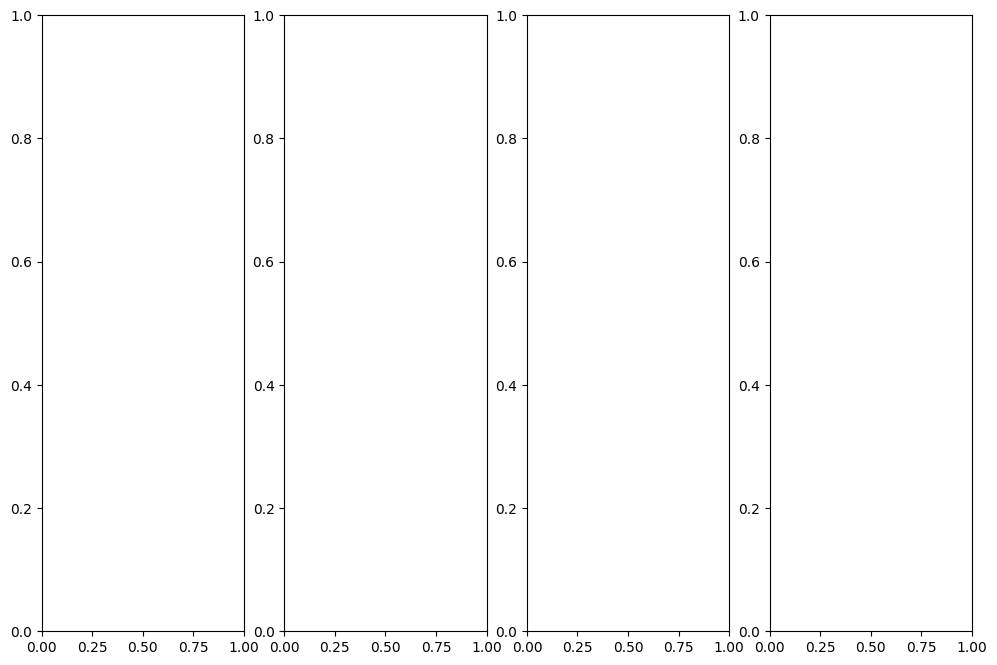

In [5]:
# quickly show the results of the ones we saved
image_count = len(images)

show_chessboards = True

make_chessboards = False  # kludge to load from disk from a list of files below
if make_chessboards:
    chess_images = []
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, target_pattern, None)
         # If found, add object points, image points (after refining them)
        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            chess_overlay = cv2.drawChessboardCorners(img.copy(), (9,6), corners2, ret)
            chess_images.append(chess_overlay)

cols = 4
rows = image_count//4 + int(image_count%4 > 0) 
fig, axs = plt.subplots(rows, cols, figsize =(12,8))
for idx, ax in enumerate(axs.flatten()[0:image_count]):
    if show_chessboards:
        ax.imshow(cv2.cvtColor(chess_images[idx], cv2.COLOR_BGR2RGB))
    else:
        ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
    ax.text(50, 80, str(idx), c='cyan', bbox=dict(fill=False, edgecolor='red', linewidth=2))
for idx, ax in enumerate(axs.flatten()[image_count:]):
    ax.axis('off')

In [6]:
plt.imshow(cv2.cvtColor(chess_images[0], cv2.COLOR_BGR2RGB))

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


---
#### save the images to a folder if you like them enough to generate a camera model

In [56]:
cal_images = Path(".") / 'cal_images'  # directory for the calibration images
cal_images.absolute()

WindowsPath('C:/CJH/Python/FRC/FRC_training/apriltag/cal_images')

In [57]:
# change to true if you want to save them for analysis later
# todo - make this a more robust method
camera = 'ms_lifecam_chess'  # name your camera
prefix = 'chess'
camera_dir = cal_images / camera
overwrite = False
save_images = True
if save_images:
    import os
    cal_images = Path('.').absolute() / 'cal_images'
    if not cal_images.is_dir():
        os.mkdir(cal_images)    
        
    try: 
        os.mkdir(camera_dir) 
    except OSError as error: 
        print(f'Likely directory exists - overwriting images! : {error}')
    for idx, im in enumerate(images):
        print(f'writing image {idx}...', end='\r')
        filepath = camera_dir / f'{camera}_cal_image_{prefix}_{idx}.jpg'
        if (filepath.is_file() and overwrite) or not filepath.is_file():
            cv2.imwrite(str(filepath), images[idx])
        else:
            pass

####  The images are saved, now load and process
* if images are in memory, could use them
* but I'll default to loading from the disk, so save them above

In [147]:
camera = 'ms_lifecam_ros_640'  # name your camera
camera_dir = cal_images / camera
fnames = glob.glob(str(camera_dir / '*.png'))
print(f'found {len(fnames)} images to test')

found 52 images to test


---
#### find all points, be sure to tell it the pattern and the square dimensions 

In [148]:
# loop through the files and generate all the image points and object points
target_pattern = (9,6)  # chessboard
square_size = 0.0254  # the squares are one inch, so 0.0254 m

resize = False  # test with different sizes

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((target_pattern[1]*target_pattern[0],3), np.float32)
objp[:,:2] = np.mgrid[ 0:target_pattern[1], 0:target_pattern[0] ].T.reshape(-1,2)
#objp = objp * square_size

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for idx, fname in enumerate(fnames):
    img = cv2.imread(fname)
    if resize:
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, target_pattern, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        chess_width = (corners[:,0,0].max()-corners[:,0,0].min())
        chess_height = (corners[:,0,1].max()-corners[:,0,1].min())
        chess_width2 = (corners2[:,0,0].max()-corners2[:,0,0].min())
        chess_height2 = (corners2[:,0,1].max()-corners2[:,0,1].min())
        msg = f'fname: {idx:2d}  Area:{chess_width*chess_height:.0f}  Initial WxH: {chess_width:6.1f} x{chess_height:6.1f}'
        msg = msg + f'   Final WxH: {chess_width2:6.1f} x{chess_height2:6.1f} '
        msg = msg + f' Delta: {chess_width-chess_width2:3.1f}, {chess_height-chess_height2:3.1f}'
        print(msg)


fname:  0  Area:119235  Initial WxH:  411.3 x 289.9   Final WxH:  411.3 x 289.9  Delta: 0.0, 0.0
fname:  1  Area:99443  Initial WxH:  396.2 x 251.0   Final WxH:  396.2 x 251.0  Delta: 0.0, 0.0
fname:  2  Area:106176  Initial WxH:  410.7 x 258.5   Final WxH:  410.7 x 258.5  Delta: 0.0, 0.0
fname:  3  Area:136647  Initial WxH:  463.2 x 295.0   Final WxH:  463.2 x 295.0  Delta: 0.0, 0.0
fname:  4  Area:152881  Initial WxH:  487.0 x 314.0   Final WxH:  487.0 x 314.0  Delta: 0.0, 0.0
fname:  5  Area:168019  Initial WxH:  513.2 x 327.4   Final WxH:  513.2 x 327.4  Delta: 0.0, 0.0
fname:  6  Area:205794  Initial WxH:  561.2 x 366.7   Final WxH:  561.2 x 366.7  Delta: 0.0, 0.0
fname:  7  Area:200434  Initial WxH:  551.4 x 363.5   Final WxH:  551.4 x 363.5  Delta: 0.0, 0.0
fname:  8  Area:171313  Initial WxH:  518.9 x 330.2   Final WxH:  518.9 x 330.2  Delta: 0.0, 0.0
fname:  9  Area:161037  Initial WxH:  497.4 x 323.8   Final WxH:  497.4 x 323.8  Delta: 0.0, 0.0
fname: 10  Area:116011  Initial

In [151]:
# run the opencv camera calibration on the above set of data
flags = 0 # cv2.CALIB_FIX_ASPECT_RATIO
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints, imageSize=gray.shape[::-1], cameraMatrix=None, distCoeffs=None,flags=flags)

In [157]:
# camera matrix - note it does not change with square size  (Camera Intrinsic Parameters)
mtx

array([[4.74164731e+03, 0.00000000e+00, 5.22009446e+01],
       [0.00000000e+00, 1.81010841e+03, 2.21953631e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [158]:
# distortion coefficients - also does not change with square size
dist

array([[ 1.86281724e+01, -3.98092183e+03, -2.39041281e-01,
        -3.95903901e-01,  1.75455768e+05]])

In [159]:
# 16 rotation vectors also do not change with square size
rvecs[0:2]
# len(rvecs)

(array([[-0.26369159],
        [-1.38953565],
        [ 0.09120432]]),
 array([[-1.70772102],
        [-7.49908878],
        [ 0.41833902]]))

In [160]:
# 16 translation vectors - their units are the units of the square size, so in our case meters
tvecs[0:2]
#len(tvecs)

(array([[ 2.03570411],
        [-2.7686368 ],
        [46.8790899 ]]),
 array([[ 1.57233776],
        [-3.38756821],
        [44.82640714]]))

#### note - the camera matrix IS dependent on resolution.  basically they each cut in half if you halve the resolution

#### what do we need for AprilTags?
* at.detector.detect() wants [fx, fy, cx, cy] and tag size - that's it
* tag size is 6", or 0.1524 meters

In [161]:
fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
print(f'[{fx:2.2f}, {fy:2.2f}, {cx:2.2f}, {cy:2.2f}]')

[4741.65, 1810.11, 52.20, 221.95]


___
#### generate some stats - look at sensitivity to a missing image
* how can we determine what is a good cal
* need multiple images AT SAME DISTANCE with 
  * SKEW - left to right tilt
  * TILT - up and down tilt
* cx and cy should be near the center of the lens, so basically #pixels_x/2 and #pixels_y/2
* fx/fy should also be equal to the ratio of the resolution, e.g. 640/480 = 1.33
  * if you get a dirty value for one, you may want to use the ratio on the better measurement to recover

In [162]:
# more futzing with stats
futz = False

center_images = [1,3,6,10,13,16,19,22,25,28,31,34,37,40,42]
edge_images = list(set(range(len(objpoints))) - set(center_images))
problem_images = [8,16,21,22,24,25,29,38,43]
test_images = list(set(range(len(objpoints))) - set(problem_images))

len(test_images)

if futz:
    df = None
    results = {}
    subset = test_images

    for i in range(len(subset)):
        # copy the image data
        obj_pt_temp = objpoints.copy()
        img_pt_temp = imgpoints.copy()

        #cull some data
        obj_pt_temp = [obj_pt_temp[j] for j in range(len(subset))]
        img_pt_temp = [img_pt_temp[j] for j in range(len(subset))]
        # get rid of one image
        obj_pt_temp.pop(i)
        img_pt_temp.pop(i)

        # run the opencv camera calibration on the above set of data
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=obj_pt_temp, imagePoints=img_pt_temp, imageSize=gray.shape[::-1], cameraMatrix=None, distCoeffs=None)

        # organize the results
        fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
        results.update({i:{'fx':round(fx,2), 'fy':round(fy,2), 'cx':round(cx,2), 'cy':round(cy,2), 'err':round(ret,2)}})
        print(f'{i:3d}: [{fx:2.2f}, {fy:2.2f}, {cx:2.2f}, {cy:2.2f}]')
    df = pd.DataFrame(results).transpose()
    df;

In [164]:
# try to change things with opencv
df = None
results = {}
# intrinsics, cv_intrinsic_array = predict_intrinsics(1280, 720, 60.2, 36.1)
flags =  0 # cv2.CALIB_USE_INTRINSIC_GUESS  + cv2.CALIB_FIX_PRINCIPAL_POINT # +  cv2.CALIB_FIX_FOCAL_LENGTH

for i in range(len(objpoints)):
    # copy the image data
    obj_pt_temp = objpoints.copy()
    img_pt_temp = imgpoints.copy()
    # get rid of one image
    obj_pt_temp.pop(i)
    img_pt_temp.pop(i)
    
    # run the opencv camera calibration on the above set of data
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=obj_pt_temp, imagePoints=img_pt_temp, imageSize=gray.shape[::-1], cameraMatrix=None, distCoeffs=None, flags=flags)
    
    # organize the results
    fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
    results.update({i:{'fx':round(fx,2), 'fy':round(fy,2), 'cx':round(cx,2), 'cy':round(cy,2), 'err':round(ret,2)}})
    print(f'{i:3d}: [{fx:2.2f}, {fy:2.2f}, {cx:2.2f}, {cy:2.2f}] fx/fy:{fx/fy:1.1f}')
df = pd.DataFrame(results).transpose()
df;

  0: [6948.18, 1684.87, -139.70, 216.63] fx/fy:4.1
  1: [6888.50, 1769.09, -113.92, 219.88] fx/fy:3.9
  2: [6709.19, 1686.02, -108.42, 222.77] fx/fy:4.0
  3: [4475.82, 1685.38, 58.73, 227.86] fx/fy:2.7
  4: [4344.55, 2035.25, 567.73, 258.42] fx/fy:2.1
  5: [6579.74, 3820.10, 495.42, 274.12] fx/fy:1.7
  6: [6070.34, 1745.47, -57.92, 223.16] fx/fy:3.5
  7: [6885.80, 1744.46, -101.05, 219.41] fx/fy:3.9
  8: [4970.87, 1746.08, 41.81, 226.39] fx/fy:2.8
  9: [5378.17, 1727.11, 44.40, 228.67] fx/fy:3.1
 10: [6189.57, 1882.48, -76.19, 220.63] fx/fy:3.3
 11: [6011.61, 1840.78, -78.05, 216.10] fx/fy:3.3
 12: [6515.95, 1685.70, -79.85, 228.16] fx/fy:3.9
 13: [5856.12, 2756.33, 40.20, 218.01] fx/fy:2.1
 14: [6426.46, 2581.60, -55.61, 219.29] fx/fy:2.5
 15: [6234.53, 1755.64, -71.91, 227.82] fx/fy:3.6
 16: [5102.29, 1816.38, 38.00, 224.95] fx/fy:2.8
 17: [5881.79, 1793.21, -29.98, 219.56] fx/fy:3.3
 18: [6340.90, 1818.53, -38.74, 218.21] fx/fy:3.5
 19: [5920.08, 1750.39, -32.49, 222.65] fx/fy:3.4
 

In [165]:
df

,fx,fy,cx,cy,err
0,6948.18,1684.87,-139.70,216.63,99.17
1,6888.50,1769.09,-113.92,219.88,99.08
2,6709.19,1686.02,-108.42,222.77,98.96
3,4475.82,1685.38,58.73,227.86,98.76
4,4344.55,2035.25,567.73,258.42,98.55
5,6579.74,3820.10,495.42,274.12,98.53
6,6070.34,1745.47,-57.92,223.16,97.77
7,6885.80,1744.46,-101.05,219.41,97.82
8,4970.87,1746.08,41.81,226.39,98.20
9,5378.17,1727.11,44.40,228.67,98.37


In [166]:
# drop bad values
#df = df.drop([1, 16])

In [167]:
# summarize everything 

fx, fy, cx, cy = df['fx'].median(), df['fy'].median(), df['cx'].median(), df['cy'].median()

for col in df.columns:
    print(f'{col:3} mean: {df[col].mean():8.2f}  median: {df[col].median():8.2f} std: {df[col].std():2.2f}')

fov_x = np.degrees(2.0 * np.arctan(image_raw.shape[0] / 2.0 / fx))
fov_y = np.degrees(2.0 * np.arctan(image_raw.shape[1] / 2.0 / fy))
print(f"\nsanity check: fov x (vertical) = {fov_x:3.1f}\N{DEGREE SIGN}  and fov y (horizontal) = {fov_y:3.1f}\N{DEGREE SIGN} ?")
print(f"sanity check: are x (vertical), y (horiz) centers ({cx:.1f}, {cy:.1f})  close to {image_raw.shape[0]//2} and {image_raw.shape[1]//2}?")

print(f"average values: [{fx:2.2f}, {fy:2.2f}, {cx:2.2f}, {cy:2.2f}]")

fx  mean:  5812.52  median:  6067.18 std: 1250.51
fy  mean:  1864.88  median:  1753.02 std: 419.83
cx  mean:     7.47  median:   -48.78 std: 171.46
cy  mean:   226.59  median:   222.64 std: 14.96
err mean:    99.72  median:    99.93 std: 0.69

sanity check: fov x (vertical) = 6.8°  and fov y (horizontal) = 40.1° ?
sanity check: are x (vertical), y (horiz) centers (-48.8, 222.6)  close to 360 and 640?
average values: [6067.18, 1753.02, -48.78, 222.64]


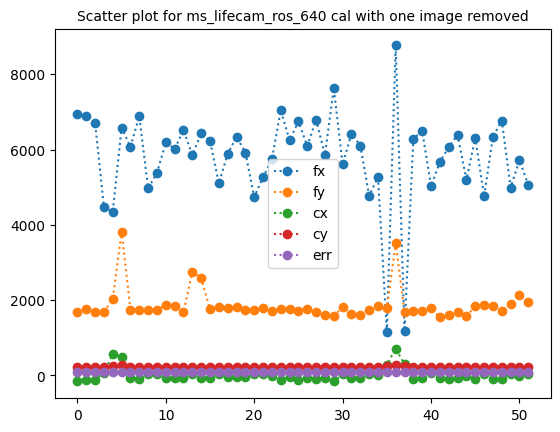

In [168]:
# show all the data
ax = df.plot(marker='o', linestyle=':')
ax.set_title(f'Scatter plot for {camera} cal with one image removed', fontsize=10);

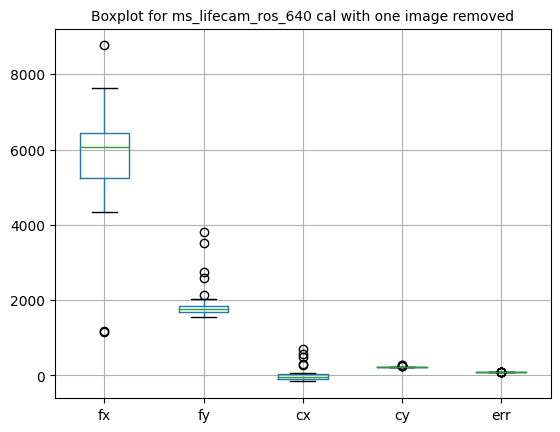

In [169]:
# visualize the spread of values
ax = df.boxplot()
ax.set_title(f'Boxplot for {camera} cal with one image removed', fontsize=10);

___
### get other images for sampling

In [243]:
resolution = (640, 480)  # try to capture images at this resolution, but cams don't always listen
usb_index = 0
mirror = True  # flip the image for easy of alignement if you are looking at it while imaging
max_images = 12
images = []  # list of images to save

# open the camera and loop through at least 12 calibration images
cam = cv2.VideoCapture(usb_index, cv2.CAP_DSHOW)  # open a regular USB cam
cam.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
print(f'opencv reporting camera with resolution {cam.get(cv2.CAP_PROP_FRAME_WIDTH)} x {cam.get(cv2.CAP_PROP_FRAME_HEIGHT)}')

cv2.waitKey(2000)

count = 0
image_count = 0
while image_count < max_images and count < 1000:  # stop runaway images
    s, image_raw = cam.read()  # read from the camera
    count = count + 1
    if s > 0:  # test if the camera actually returned a success 
        image_count = image_count + 1
        images.append(image_raw)
        print(f'saving image {image_count} ...', end='\r') 
        k = cv2.waitKey(1000)
cam.release()
print('\nDone')

opencv reporting camera with resolution 640.0 x 480.0
saving image 12 ...
Done


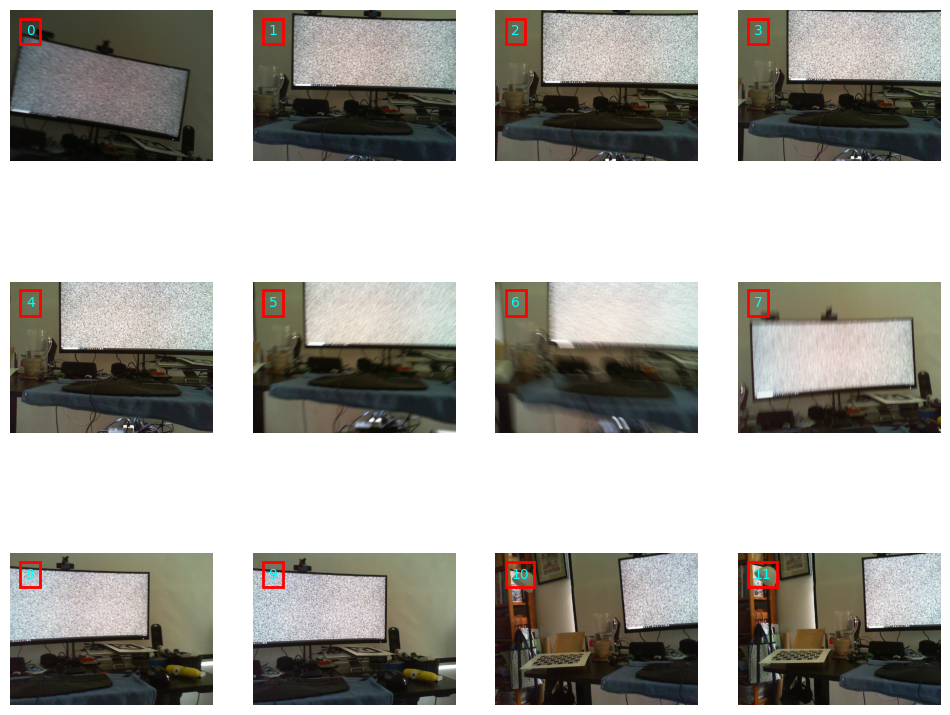

In [6]:
# quickly show the results of the ones we saved
image_count = len(images)
cols = 4
rows = image_count//4 + int(image_count%4 > 0) 
fig, axs = plt.subplots(rows, cols, figsize =(12,10))
for idx, ax in enumerate(axs.flatten()[0:image_count]):
    ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
    ax.text(50, 80, str(idx), c='cyan', bbox=dict(fill=False, edgecolor='red', linewidth=2))
for idx, ax in enumerate(axs.flatten()[image_count:]):
    ax.axis('off')

In [10]:
good_images = [1,2,3,4,8,9,10,11] 
images = [images[idx] for idx in good_images]

In [11]:
# change to true if you want to save them for analysis later
# todo - make this a more robust method
cal_images = Path(".") / 'cal_images'  # directory for the calibration images
cal_images.absolute()
camera = 'ms_lifecam_640c'  # name your camera
camera_dir = cal_images / camera

save_images = True
if save_images:
    import os
    cal_images = Path('.').absolute() / 'cal_images'
    if not cal_images.is_dir():
        os.mkdir(cal_images)    
    try: 
        os.mkdir(camera_dir) 
    except OSError as error: 
        print(f'Likely directory exists - overwriting images! : {error}')
    for idx, im in enumerate(images):
        print(f'writing image {idx}...', end='\r')
        filepath = camera_dir / f'{camera}_cal_image_{idx}.jpg'
        cv2.imwrite(str(filepath), images[idx])

Likely directory exists - overwriting images! : [WinError 183] Cannot create a file when that file already exists: 'cal_images\\ms_lifecam_640c'
